In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb
import math

conn = duckdb.connect(database=':memory:')

In [16]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
fraud_df = pd.read_csv('creditcard.csv',sep=',')

conn.execute("CREATE TABLE fraud_data AS SELECT * FROM fraud_df")

In [8]:
fraud_df[['Amount']].head()

,Amount
0,149.62
1,2.69
2,378.66
3,123.50
4,69.99


In [15]:
df = fraud_df
# print(df.info)
print(df.columns)
print(df.dtypes)
# print(df.describe())
print('Complete size of data set:')
print(df.shape[0])
# checking for missing values
print('Num values missing:')
print(df.isna().sum())

N_norm = df[df['Class'] == 0].shape[0]
N_fraud = df[df['Class'] == 1].shape[0]
print('Number of non-fraudulent transactions:',
      N_norm)
print('Number of fraudulent transactions:',
      N_fraud)
print('Percent of fraudulent transactions:',
      100*N_fraud/df.shape[0])

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object
Complete size of data set:
284807
Num values missing:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V

So there are no missing values in the data set.

There is a very low percentage of fraudulent transactions; 0.17%.

   Class  N_cases   N_tot  frac_cases
0      0   284315  284807    0.998273
1      1      492  284807    0.001727


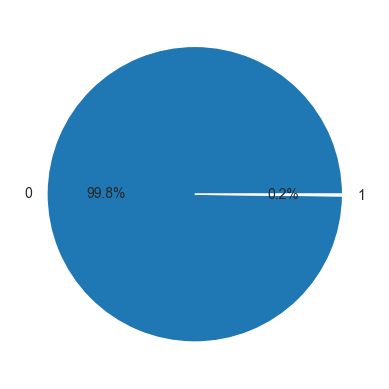

In [19]:
fraud_br = conn.execute(f"""
    SELECT *, N_cases / N_tot AS frac_cases
    FROM (
        SELECT Class, COUNT(*) AS N_cases
        FROM fraud_data
        WHERE Class is not null
        GROUP BY Class
    )
    INNER JOIN (
        SELECT COUNT(*) AS N_tot FROM fraud_data WHERE Class is not null
    )
    ON true""").df()
print(fraud_br)


# Create the pie chart with percentages
plt.pie(fraud_br['frac_cases'], labels=fraud_br['Class'], autopct='%.1f%%', startangle=0)
#plt.show()
plt.savefig('breakdown_plots/fraud_pie.png')
# plt.clf()

In [48]:

df_orig = fraud_df
columns = list(df_orig.columns)
columns.remove('Class')
# bins = np.linspace(min(df_orig[col]), max(df_orig[col]), 50)
for col in columns:
      minimum = int(math.floor(min(df_orig[col])))
      if col == 'Amount':
            maximum = int(math.ceil(df_orig[col].mean() + 10*df_orig[col].std()))
      else:
            maximum = int(df_orig[col].max())
      bins = np.linspace(minimum, maximum, 50)

      plt.hist(df_orig[col], bins, alpha=0.5, label='0', density=True)
      plt.xlabel(col)
      plt.ylabel('Probability Density')
      plt.title(f'{col} Histogram')
      plt.savefig(f'breakdown_plots/Histogram/{col}_hist.png')
      plt.clf()

<Figure size 640x480 with 0 Axes>

In [55]:
from sklearn.model_selection import train_test_split
df = fraud_df
# Assuming 'df' is your DataFrame and 'target' is the target column
# Separate majority and minority classes
df_majority = df[df.Class == 0] # Assuming 0 is the majority class
df_minority = df[df.Class == 1] # Assuming 1 is the minority class

from sklearn.utils import resample

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority), # to match minority class size
                                   random_state=999)  # for reproducibility

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [109]:
df_balanced.shape

(984, 31)

In [58]:

df_orig = df_balanced
columns = list(df_orig.columns)
columns.remove('Class')
# bins = np.linspace(min(df_orig[col]), max(df_orig[col]), 50)
for col in columns:
      minimum = int(math.floor(min(df_orig[col])))
      if col == 'Amount':
            maximum = int(math.ceil(df_orig[col].mean() + 10*df_orig[col].std()))
      else:
            maximum = int(df_orig[col].max())
      bins = np.linspace(minimum, maximum, 50)

      plt.hist(df_orig[col], bins, alpha=0.5, label='0', density=True)
      plt.xlabel(col)
      plt.ylabel('Probability Density')
      plt.title(f'{col} Histogram')
      plt.savefig(f'breakdown_plots/Histograms_Downsample/{col}_hist.png')
      plt.clf()

<Figure size 640x480 with 0 Axes>

In [60]:
fraud_df.shape

(284807, 31)

In [64]:

df_orig = df_balanced
columns = list(df_orig.columns)
columns.remove('Class')
breakdown_var = 'Class'
# bins = np.linspace(min(df_orig[col]), max(df_orig[col]), 50)
for col in columns:
      minimum = int(math.floor(min(df_orig[col])))
      if col == 'Amount':
            maximum = int(math.ceil(df_orig[col].mean() + 10*df_orig[col].std()))
      else:
            maximum = int(df_orig[col].max())
      bins = np.linspace(minimum, maximum, 50)
      var_list = list(np.unique(df_orig[breakdown_var]))
      dict_comp = {}
      for var in var_list:
          dict_comp[var] = df_orig[df_orig[breakdown_var] == var]
      for var in var_list:
          plt.hist(dict_comp[var][col], bins, alpha=0.5, label=var, density=True)
      plt.legend(loc='upper right')

      # plt.savefig('histogram_plots/'+col+'_histogram.png')
      # plt.clf()
      # plt.hist(df_orig[col], bins, alpha=0.5, label='0', density=True)
      plt.xlabel(col)
      plt.ylabel('Probability Density')
      plt.title(f'{col} Histogram with Downsampled Data')
      plt.tight_layout()
      # plt.show()
      plt.savefig(f'breakdown_plots/Histograms_Downsample_Split/{col}_hist.png')
      plt.clf()

<Figure size 640x480 with 0 Axes>

In [66]:
from sklearn.model_selection import train_test_split

df_orig_bal = df_balanced
columns = list(df_orig_bal.columns)
columns.remove('Class')
# Separate features (X) and target variable (y)
X = df_orig_bal[columns]
y = df_orig_bal['Class']

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=999, stratify=y
)

In [110]:
X_train.shape

(885, 30)

Ranked Feature Importances:
   Feature  Importance
14     V14    0.192361
10     V10    0.131596
4       V4    0.095359
11     V11    0.067816
12     V12    0.067116
17     V17    0.056858
16     V16    0.050040
3       V3    0.049879
9       V9    0.038066
2       V2    0.031352
7       V7    0.028320
27     V27    0.018872
18     V18    0.017905
21     V21    0.016670
8       V8    0.013683
6       V6    0.013631
19     V19    0.013144
29  Amount    0.011860
20     V20    0.010855
28     V28    0.009614
23     V23    0.007850
5       V5    0.007610
15     V15    0.007202
1       V1    0.006601
26     V26    0.006537
24     V24    0.006347
22     V22    0.006251
13     V13    0.006013
0     Time    0.005567
25     V25    0.005023


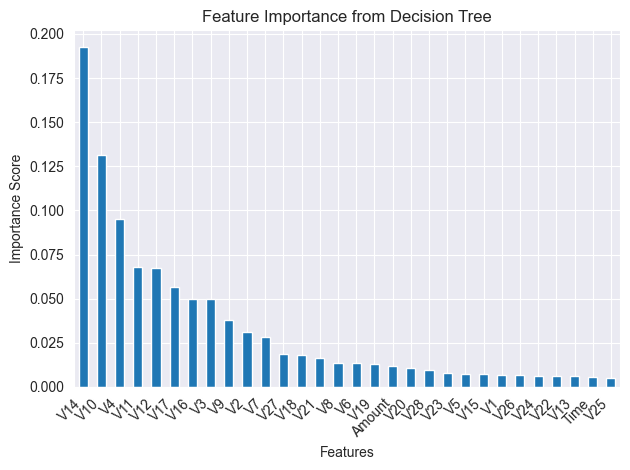

In [111]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=999)
model.fit(X_train, y_train)

feature_names = columns
# 4. Access feature importances
importances = model.feature_importances_
# 5. Create a DataFrame for better visualization and sorting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 6. Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 7. Print or visualize the ranked features
print("Ranked Feature Importances:")
print(feature_importance_df)

feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feature_importances.plot.bar()
plt.title('Feature Importance from Decision Tree')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# plt.savefig(f'feature_scores.png')
plt.show()


Now based on looking at this in combination with the histograms I created, the last variable that seems to have differentiating behaviour on the Class variable is V19.  As such I will remove all the variables Amount and onwards from our list of variables.

This can be done differently, and more scientifically.  For example one can train the model for each separate list of variables including one more at a time.  Something like Forward or Backward Stepwise Selection methods.  And one doesn't have to use this metric either.

To save myself some time though, I'm just trying to get a half decent result relatively quickly and this is what I'm choosing to do.

In [75]:
final_feature_list = list(feature_importance_df[feature_importance_df.Importance > 0.0119].Feature)
X_train2 = X_train[final_feature_list]
X_test2 = X_test[final_feature_list]

Perform Random Forest

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.datasets import make_classification
import scipy.stats as stats


random_grid = {'bootstrap': [True],
               'max_depth': [3, 5, 10, None],
               'max_features': ['sqrt'],
               'min_samples_leaf': [2, 4, 6, 8],
               'min_samples_split': [2, 3, 4],
               'n_estimators': [100, 150, 200]}


rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
    scoring='accuracy',
    random_state=999,
    n_jobs=-1,
    verbose=0
)
# Fit the random search model
rf_random.fit(X_train.to_numpy(), y_train.values.ravel())

print(rf_random.best_params_)
print(rf_random.best_score_)
print(rf_random.best_estimator_)

# Evaluate the best model on the test set
best_model_rf = rf_random.best_estimator_
test_accuracy_rf = best_model_rf.score(X_test.to_numpy(), y_test.values.ravel())
print("Test set accuracy with best model:", test_accuracy_rf)

Random Forest - best choice of hyperparameters: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
94.23% CV (5-fold) accuracy on a downsampled data set that is split 50-50, that's pretty darned good.

On the test set this performs close to 95% accurate, but this is close to the CV average of 93.93%.

Perform XGBoost.

In [114]:
# begin by standardizing variables
mean_vals = X_train2.mean()
std_vals = X_train2.std()
X_train_std = (X_train2 - mean_vals)/std_vals
X_test_std = (X_test2 - mean_vals)/std_vals
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Define the hyperparameter distributions for RandomizedSearchCV
# Using scipy.stats distributions for continuous parameters
param_dist = {
    'n_estimators': stats.randint(100, 500),  # Number of boosting rounds
    'learning_rate': stats.uniform(0.01, 0.2),  # Step size shrinkage
    'max_depth': stats.randint(3, 10),  # Maximum depth of a tree
    'subsample': stats.uniform(0.6, 0.4),  # Subsample ratio of the training instance
    'colsample_bytree': stats.uniform(0.6, 0.4),  # Subsample ratio of columns when constructing each tree
    'gamma': stats.uniform(0, 0.2),  # Minimum loss reduction required to make a further partition
    'reg_alpha': stats.uniform(0, 0.1),  # L1 regularization term on weights
    'reg_lambda': stats.uniform(0, 1)  # L2 regularization term on weights
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
    scoring='accuracy',
    random_state=999,
    n_jobs=-1,
    verbose=0
)

random_search_xgb.fit(X_train_std.to_numpy(), y_train.values.ravel())

print("\nBest set of hyperparameters:", random_search_xgb.best_params_)
print("Best cross-validation score:", random_search_xgb.best_score_)
print("Best cross-validation estimator:", random_search_xgb.best_estimator_)

# Evaluate the best model on the test set
best_model_xgb = random_search_xgb.best_estimator_
test_accuracy_xgb = best_model_xgb.score(X_test_std.to_numpy(), y_test.values.ravel())
print("Test set accuracy with best model:", test_accuracy_xgb)



Best set of hyperparameters: {'colsample_bytree': np.float64(0.65234695245181), 'gamma': np.float64(0.16350242907332466), 'learning_rate': np.float64(0.16604690153357163), 'max_depth': 5, 'n_estimators': 120, 'reg_alpha': np.float64(0.02104653543525822), 'reg_lambda': np.float64(0.9347011734414674), 'subsample': np.float64(0.6494923628434196)}
Best cross-validation score: 0.9435028248587571
Best cross-validation estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.65234695245181), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(0.16350242907332466), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.16604690153357163), max_bin=None,
              max

XGBoost seems to perform a little better than random forest with approximately 94.35% CV (5-fold) accuracy.

Perform Logistic Regression

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy.stats import loguniform

# begin by standardizing variables
mean_vals = X_train2.mean()
std_vals = X_train2.std()
X_train_std = (X_train2 - mean_vals)/std_vals
X_test_std = (X_test2 - mean_vals)/std_vals
# Define the log reg model
logistic_regression = LogisticRegression(solver='liblinear', random_state=999)

# Define the hyperparameter distributions for RandomizedSearchCV
# Using scipy.stats distributions for continuous parameters
param_distributions = {
    'C': loguniform(1e-5, 100),  # Regularization strength
    'penalty': ['l1', 'l2']      # Regularization type
}

random_search_log = RandomizedSearchCV(
    estimator=logistic_regression,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
    scoring='accuracy',
    random_state=999,
    n_jobs=-1,
    verbose=0
)

random_search_log.fit(X_train_std.to_numpy(), y_train.values.ravel())

print("\nBest set of hyperparameters:", random_search_log.best_params_)
print("Best cross-validation score:", random_search_log.best_score_)
print("Best cross-validation estimator:", random_search_log.best_estimator_)

# Evaluate the best model on the test set
best_model_log = random_search_log.best_estimator_
test_accuracy_log = best_model_log.score(X_test_std.to_numpy(), y_test.values.ravel())
print("Test set accuracy with best model:", test_accuracy_log)



Best set of hyperparameters: {'C': np.float64(1.041022459301857), 'penalty': 'l2'}
Best cross-validation score: 0.9446327683615818
Best cross-validation estimator: LogisticRegression(C=np.float64(1.041022459301857), random_state=999,
                   solver='liblinear')
Test set accuracy with best model: 0.9595959595959596


Logistic regression has an excellent CV (5-fold) score of 94.46327%.

Perform Naive Bayes

In [98]:
from sklearn.naive_bayes import BernoulliNB

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy.stats import loguniform

# begin by standardizing variables
mean_vals = X_train2.mean()
std_vals = X_train2.std()
X_train_std = (X_train2 - mean_vals)/std_vals
X_test_std = (X_test2 - mean_vals)/std_vals
# Define the Bernoulli Naive Bayes (good for binary classification) model
bnb = BernoulliNB()

# Define the hyperparameter search space for alpha (Laplace smoothing parameter)
# A log-uniform distribution is often suitable for 'alpha'
param_distributions = {
    'alpha': loguniform.rvs(1e-3, 1e2, size=200) # Example range for alpha
}

random_search_nb = RandomizedSearchCV(
    estimator=bnb,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
    scoring='accuracy',
    random_state=999,
    n_jobs=-1,
    verbose=0
)

random_search_nb.fit(X_train_std.to_numpy(), y_train.values.ravel())

print("\nBest set of hyperparameters:", random_search_nb.best_params_)
print("Best cross-validation score:", random_search_nb.best_score_)
print("Best cross-validation estimator:", random_search_nb.best_estimator_)

# Evaluate the best model on the test set
best_model_nb = random_search_nb.best_estimator_
test_accuracy_nb = best_model_nb.score(X_test_std.to_numpy(), y_test.values.ravel())
print("Test set accuracy with best model:", test_accuracy_nb)



Best set of hyperparameters: {'alpha': np.float64(0.2770825422246985)}
Best cross-validation score: 0.9118644067796609
Best cross-validation estimator: BernoulliNB(alpha=np.float64(0.2770825422246985))
Test set accuracy with best model: 0.9090909090909091


Naive Bayes doesn't perform as well as Random forest, XGBoost or Logistic regression with about 91.2% accuracy.

Perform Support Vector Classification

In [105]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from scipy.stats import loguniform

# begin by standardizing variables
mean_vals = X_train2.mean()
std_vals = X_train2.std()
X_train_std = (X_train2 - mean_vals)/std_vals
X_test_std = (X_test2 - mean_vals)/std_vals
# Define the Support Vector Classification model
svc = SVC(random_state=999)

param_distributions = {
    'C': loguniform(1e-3, 1e3),  # C can range from 0.001 to 1000 on a log scale
    'gamma': loguniform(1e-4, 1e-1), # gamma can range from 0.0001 to 0.1 on a log scale
    'kernel': ['rbf', 'linear'] # Example: trying different kernels
}

random_search_svc = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
    scoring='accuracy',
    random_state=999,
    n_jobs=-1,
    verbose=0
)

random_search_svc.fit(X_train_std.to_numpy(), y_train.values.ravel())

print("\nBest set of hyperparameters:", random_search_svc.best_params_)
print("Best cross-validation score:", random_search_svc.best_score_)
print("Best cross-validation estimator:", random_search_svc.best_estimator_)

# Evaluate the best model on the test set
best_model_svc = random_search_svc.best_estimator_
test_accuracy_svc = best_model_svc.score(X_test_std.to_numpy(), y_test.values.ravel())
print("Test set accuracy with best model:", test_accuracy_svc)



Best set of hyperparameters: {'C': np.float64(1.2249995127472268), 'gamma': np.float64(0.0037039528862068648), 'kernel': 'linear'}
Best cross-validation score: 0.9412429378531073
Best cross-validation estimator: SVC(C=np.float64(1.2249995127472268), gamma=np.float64(0.0037039528862068648),
    kernel='linear', random_state=999)
Test set accuracy with best model: 0.9595959595959596


Support Vector Classification performs quite well too, with over 94% accuracy.

The best performing models are Random Forest, XGBoost, Logistic Regression and Support Vector Classification.

I want to see how hard voting works here when used on XGBoost, Logistic Regression and Support Vector Classification.  I've removed Random Forest because it inherently will behave similarly to XGBoost and we want predictors with differing methodologies.

In [108]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
model1 = best_model_xgb
model2 = best_model_log
model3 = best_model_svc
# SVC?
# Create a VotingClassifier
# Hard Voting

ensemble_model = VotingClassifier(
    estimators=[('xgb', model1), ('log', model2), ('SVC', model3)],
    voting='hard'  # 'hard' for majority voting (class with most votes)
)


scores_hard = cross_val_score(ensemble_model, X_train_std, y_train,
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
                              scoring='accuracy')
print(f"Hard Voting Classifier Accuracy (Cross-Validation): "
      f"{np.mean(scores_hard):.4f} +/- {np.std(scores_hard):.4f}")


ensemble_model.fit(X_train_std, y_train)

y_pred_ensemble = ensemble_model.predict(X_test_std)
# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy on test set (Hard Voting): {ensemble_accuracy:.4f}")


Hard Voting Classifier Accuracy (Cross-Validation): 0.9446 +/- 0.0097
Ensemble Model Accuracy on test set (Hard Voting): 0.9596


The average cross validation score ties the best performing model which is Logistic Regression.

The result on the test set is better only by a very small amount.